In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import os
import re
import string
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.optimize as so
import sympy as sym
sym.init_printing(use_unicode=False, wrap_line=True)

In [36]:
# データの読み込み
df = pd.read_csv("./data/wholetime.csv")
df.head()

/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4926/377148153.py:2: DtypeWarning: Columns (2,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/wholetime.csv")


,end_lat,end_lng,end_station_id,end_station_name,ended_at,member_casual,ride_id,rideable_type,start_lat,start_lng,start_station_id,start_station_name,started_at,distance,start_lat_lng,end_lat_lng
0,41.9322,-87.6586,152.0,Lincoln Ave & Diversey Pkwy,2020-04-26 18:12:03,member,A847FADBBC638E45,docked_bike,41.8964,-87.6610,86,Eckhart Park,2020-04-26 17:45:14,3.981346,"(41.8964, -87.661)","(41.9322, -87.6586)"
1,41.9306,-87.7238,499.0,Kosciuszko Park,2020-04-17 17:17:03,member,5405B80E996FF60D,docked_bike,41.9244,-87.7154,503,Drake Ave & Fullerton Ave,2020-04-17 17:08:54,0.979629,"(41.9244, -87.7154)","(41.9306, -87.7238)"
2,41.8679,-87.6230,255.0,Indiana Ave & Roosevelt Rd,2020-04-01 18:08:36,member,5DD24A79A4E006F4,docked_bike,41.8945,-87.6179,142,McClurg Ct & Erie St,2020-04-01 17:54:13,2.984661,"(41.8945, -87.6179)","(41.8679, -87.623)"
3,41.8992,-87.6722,657.0,Wood St & Augusta Blvd,2020-04-07 13:02:31,member,2A59BBDF5CDBA725,docked_bike,41.9030,-87.6975,216,California Ave & Division St,2020-04-07 12:50:19,2.141375,"(41.903, -87.6975)","(41.8992, -87.6722)"
4,41.9695,-87.6547,323.0,Sheridan Rd & Lawrence Ave,2020-04-18 11:15:54,casual,27AD306C119C6158,docked_bike,41.8902,-87.6262,125,Rush St & Hubbard St,2020-04-18 10:22:59,9.119685,"(41.8902, -87.6262)","(41.9695, -87.6547)"


In [3]:
# Get the node_list, edge_list and timestamp
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
active_node_list, edge_list, timestamp = return_nm(df)

In [9]:
# データセットをいくつかのグループに分ける
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')]
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')]
df_p3 = df[(df['started_at'] >= '2020-11-01') & (df['started_at'] < '2021-03-01')]
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')]

node_list_p1, edge_list_p1, timestamp_p1 = return_nm(df_p1)
node_list_p2, edge_list_p2, timestamp_p2 = return_nm(df_p2)
node_list_p3, edge_list_p3, timestamp_p3 = return_nm(df_p3)
node_list_p4, edge_list_p4, timestamp_p4 = return_nm(df_p4)


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4926/959480390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['started_at'] = pd.to_datetime(df['started_at'])
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4926/959480390.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'])
/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4926/959480390.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

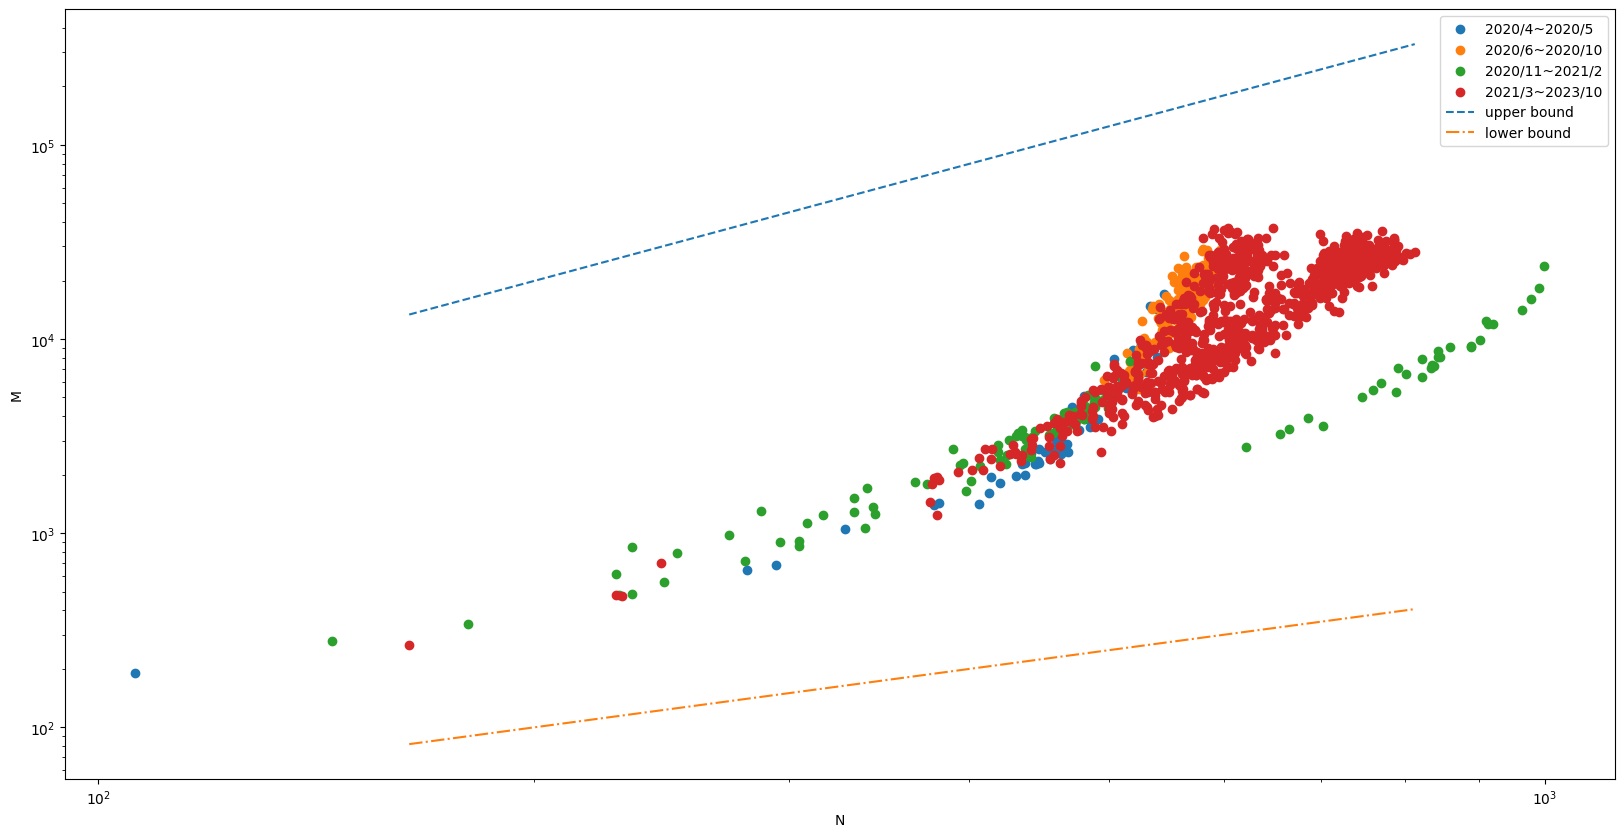

In [7]:
node_list = [node_list_p1, node_list_p2, node_list_p3, node_list_p4]
node_list = max(node_list, key=len)

nn = len(node_list)
xmin = min(node_list)
xmax = max(node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(20, 10))
plt.scatter(node_list_p1, edge_list_p1, label='2020/4~2020/5')
plt.scatter(node_list_p2, edge_list_p2, label='2020/6~2020/10')
plt.scatter(node_list_p3, edge_list_p3, label='2020/11~2021/2')
plt.scatter(node_list_p4, edge_list_p4, label='2021/3~2023/10')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


In [60]:
def model1(m, m0, kappa):
    Np = ((1 + np.sqrt(1 + ((32*m0) / kappa))) / 2)
    res = np.array(Np * (1 - (2 / (kappa * Np)) * (1 - (1 - (kappa / 2)) ** Np) ))
    if res.any() < 0:
        return 0
    else:
        return res

In [112]:
popt, pcov = curve_fit(model1,edge_list_sample,active_node_list_sample,[2, 0.01])
print(popt)

Np = []
for i in range(len(edge_list_sample)):
    Np.append((1+np.sqrt(1+32*edge_list_sample[i]/popt[1]))/2)

[1.77858385e+02 2.61432123e-06]


/var/folders/pm/4cgtm7w90fbgczj718s4vvk40000gn/T/ipykernel_4926/1212891665.py:2: RuntimeWarning: invalid value encountered in sqrt
  Np = ((1 + np.sqrt(1 + ((32*m0) / kappa))) / 2)


In [114]:
N_fit = []
M_fit = []
kappa = 2.614132123e-06

for i in range(len(active_node_list_sample)):
    N_fit.append(calc_N(Np[i], kappa))

for i in range(len(edge_list_sample)):
    M_fit.append(calc_M(Np[i], kappa))

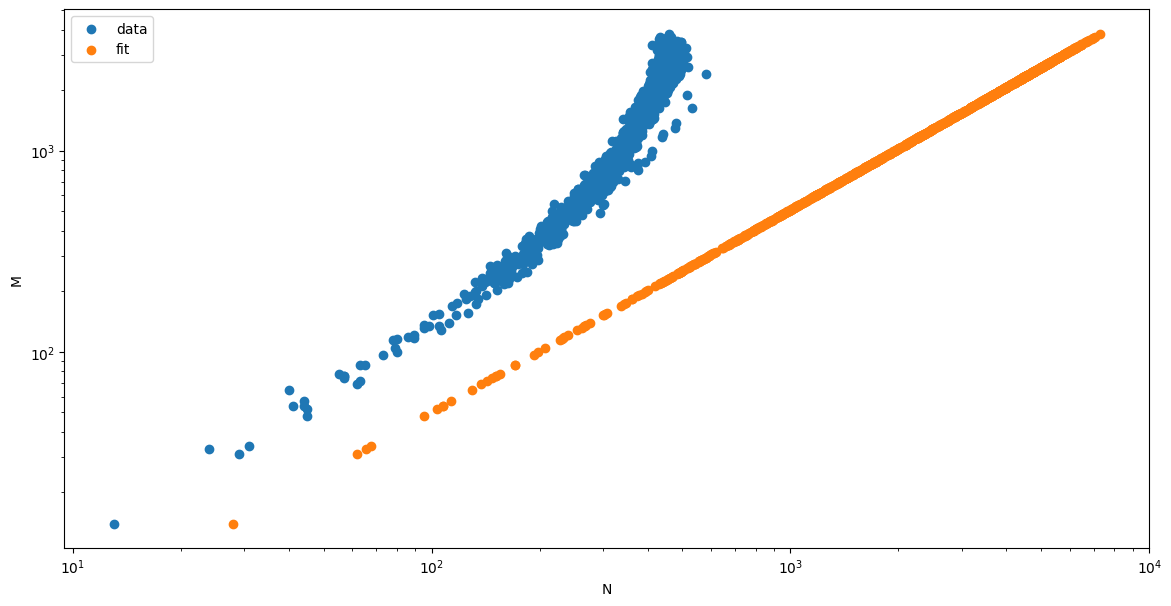

In [115]:
plt.figure(figsize=(14, 7))
plt.scatter(active_node_list_sample, edge_list_sample, label='data')
plt.scatter(N_fit, M_fit, label='fit')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [100]:
def model2(n, n0,Np):
    a = 8*n0/(Np**2-Np)
    return Np-2/a*(1-(1-(a/2)**Np))

In [102]:
popt, pcov = curve_fit(model2, active_node_list_sample, edge_list_sample, [2, 1000])
print(popt)

[   2.         1485.34952978]


In [103]:
Np = 1485.35
kappa = []
for i in range(len(edge_list_sample)):
    kappa.append(8*edge_list_sample[i]/(Np**2-Np))

In [105]:
def calc_N(Np, kappa):
    return Np * (1 - (2 / (kappa * Np))*(1 - (1 - (kappa / 2))**Np))

In [107]:
def calc_M(Np, kappa):
    return (kappa * Np * (Np - 1)) / 8

In [106]:
# Np = 1485.35
# Npとkappaを用いて、N, Mを計算する
N_fit = []
M_fit = []

for i in range(len(active_node_list_sample)):
    N_fit.append(calc_N(Np, kappa[i]))

In [108]:
for j in range(len(edge_list_sample)):
    M_fit.append(calc_M(Np, kappa[j]))

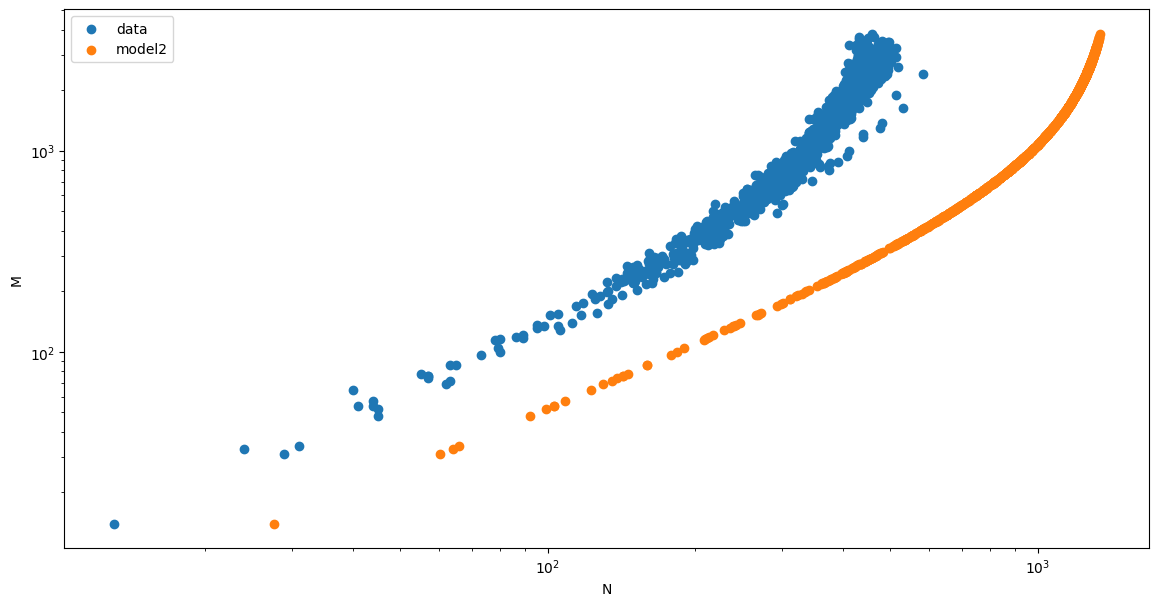

In [109]:
# modell2からフィッティング
node_fit = np.linspace(0, 1276, 1276)
edge_fit = model2(node_fit, *popt)
plt.figure(figsize=(14, 7))
plt.scatter(active_node_list_sample, edge_list_sample, label='data')
plt.scatter(N_fit, M_fit, label='model2')
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [45]:
df_sample = df.sample(frac=0.1, random_state=0)

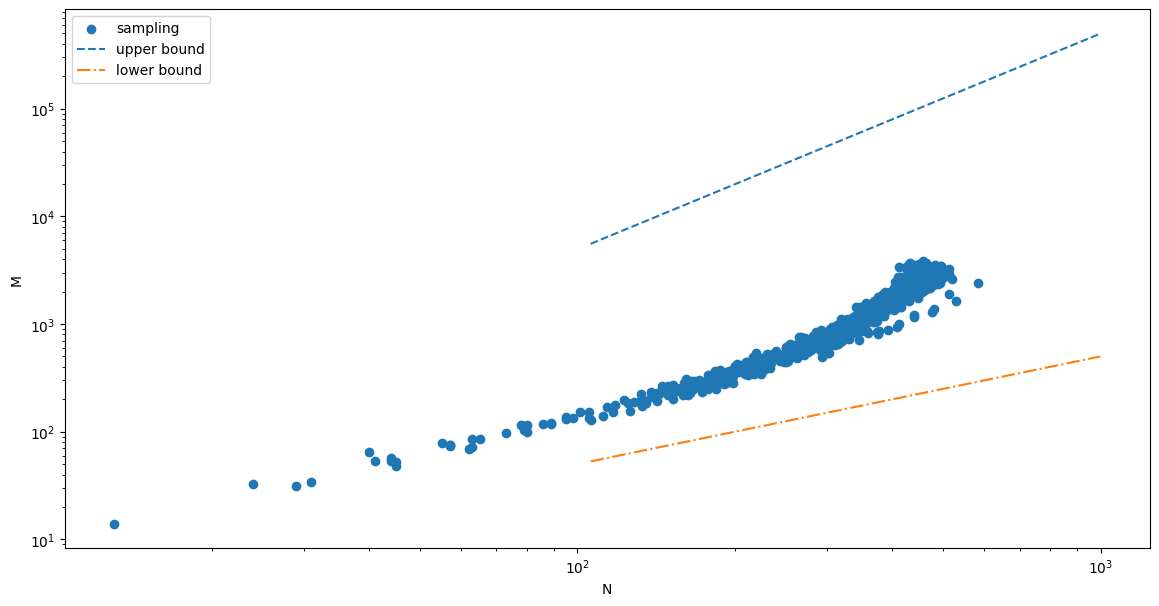

In [50]:
# Get the node_list, edge_list and timestamp
active_node_list_sample, edge_list_sample, timestamp_sample = return_nm(df_sample)

# プロット
nn = len(active_node_list)
xmin = min(active_node_list)
xmax = max(active_node_list)
p = np.linspace(xmin, xmax, nn)
upper_bound = (p**2-p)/2
lower_bound = p/2

plt.figure(figsize=(14, 7))
plt.scatter(active_node_list_sample, edge_list_sample, label='sampling')
plt.plot(p, upper_bound, '--', label="upper bound")
plt.plot(p, lower_bound, '-.', label="lower bound")
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [89]:
# 変数を宣言する
N = sym.Symbol('N')
M = sym.Symbol('M')
kappa = sym.Symbol('kappa')
Np = sym.Symbol('Np')

In [90]:
sym.factorint(100)

In [91]:
N = Np*(1-(2/(kappa*Np))*(1-(1-(kappa/2))**Np))
M = (Np**2-Np)*kappa/8

In [92]:
N

In [95]:
# NとMの非線形な連立方程式を解く



